<a href="https://colab.research.google.com/github/OnurcanKoken/Coursera_Machine_Learning/blob/main/Custom_Models_Layers_and_Loss_Functions_with_TensorFlow/Custom_Models_ResNet_Week4/Subclassing_Implementing_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Implementing ResNet

In this lab, you will continue exploring Model subclassing by building a more complex architecture. 

[Residual Networks](https://arxiv.org/abs/1512.03385) make use of skip connections to make deep models easier to train. 
- There are branches as well as many repeating blocks of layers in this type of network. 
- You can define a model class to help organize this more complex code, and to make it easier to re-use your code when building the model.
- As before, you will inherit from the [Model class](https://keras.io/api/models/model/) so that you can make use of the other built-in methods that Keras provides.

Date: 27th of May, 2021

## Imports

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

## Implement Model subclasses

As shown in the lectures, you will first implement the Identity Block which contains the skip connections (i.e. the `add()` operation below. This will also inherit the Model class and implement the `__init__()` and `call()` methods.

In [2]:
# residual block
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__(name='')
        # filters -> number of filters in each convolutional layer
        # kernel_size -> the dimention/size/shape like 3 by 3 convolutions
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
    
    def call(self, input_tensor):
        # the sequence - functional API
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)

        # short cut / skip connection part
        x = self.add([x, input_tensor])
        x = self.act(x)
        return x

From there, you can build the rest of the ResNet model. 
- You will call your `IdentityBlock` class two times below and that takes care of inserting those blocks of layers into this network.

In [3]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity blocks that you just defined
        # 64 filters that are 3 by 3
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
      # the sequence - functional API
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)

## Training the Model

As mentioned before, inheriting the Model class allows you to make use of the other APIs that Keras provides, such as:
- training
- serialization
- evaluation

You can instantiate a Resnet object and train it as usual like below:

**Note**: If you have issues with training in the Coursera lab environment, you can also run this in Colab using the "open in colab" badge link.

In [4]:
# utility function to normalize the images and return (image, label) pairs.
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

# create a ResNet instance with 10 output units for MNIST
resnet = ResNet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# load and preprocess the dataset
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='./data')
dataset = dataset.map(preprocess).batch(32)

# train the model.
resnet.fit(dataset, epochs=1)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to ./data/mnist/3.0.1. Subsequent calls will reuse this data.
1875/1875 [==============================] - 219s 116ms/step - loss: 0.1336 - accuracy: 0.9639


# Displaying the Model - Edited Version

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

In [6]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes, dim):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        # Use the Identity/Residual blocks that you just defined
        # 64 filters that are 3 by 3
        self.id1a = IdentityBlock(64, 3)
        self.id1b = IdentityBlock(64, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # the sequence - functional API
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        # insert the identity blocks in the middle of the network
        x = self.id1a(x)
        x = self.id1b(x)

        x = self.global_pool(x)
        return self.classifier(x)
      
    # AFAIK: The most convenient method to print model.summary() 
    # similar to the sequential or functional API like.
    def build_graph(self):
        x = Input(shape=(dim))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [7]:
dim = (28,28, 1)
model = ResNet(10, dim)
model.build((None, *dim))
model.build_graph().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
identity_block_2 (IdentityBl (None, 9, 9, 64)          74368     
_________________________________________________________________
identity_block_3 (IdentityBl (None, 9, 9, 64)          74368 

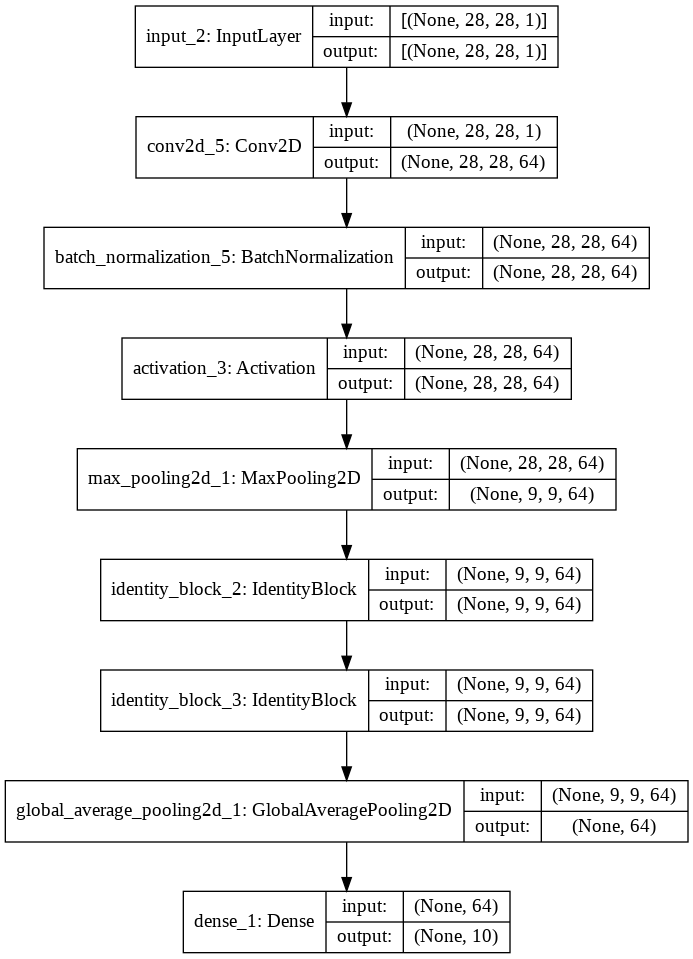

In [8]:
# Just showing all possible argument for newcomer.  
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)
# Reference: https://stackoverflow.com/questions/61427583/how-do-i-plot-a-keras-tensorflow-subclassing-api-model